## Data Understanding 

In [198]:
#imports 

import pandas as pd
import numpy as np
from matplotlib import pyplot  as plt 
import seaborn as sns

#stats
from scipy.stats import iqr

#sklearn
from sklearn.model_selection import train_test_split

In [199]:
cars = pd.read_csv("data/vehicles.csv")

In [200]:
cars.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


I can read a csv file lol.

## Feature Engineering 

- 'id' doesn't provide any useful information. It is the transaction id of the sale from the website from where the data was scraped. 

In [201]:
# X = cars.drop(['id','region','price','model','title_status','transmission','VIN','size','state'],axis=1)
# y = cars[['price']]

In [202]:
#Dropping 'id'
cars.drop(['id'],axis=1,inplace=True)

### State and Region

For the sake of this project we are not considering geographical location(which includes both state & location) in our regression model.

In [203]:
#Dropping 'region' & 'state'
cars.drop(['region','state'],axis=1,inplace=True)

### Price 

This feature shows the price the vehicle was sold for. This will be our target 'y' in our regression model to predict the prices.

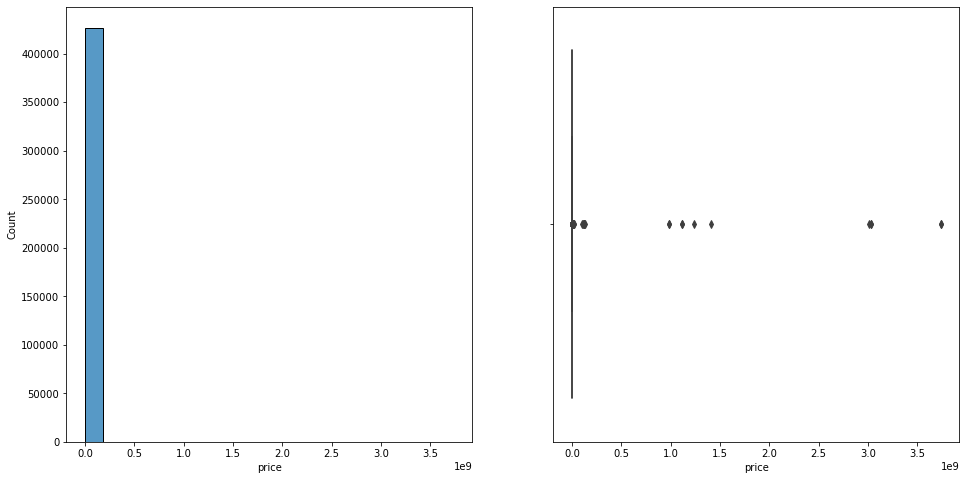

In [204]:
#converting the datatype to integer
cars.price.astype('int')

#Plotting the histogram of 'price'
plt.figure(figsize=(16,8))
plt.subplot(121)
sns.histplot(data=cars,x='price',bins=20)
plt.subplot(122)
sns.boxplot(data=cars,x='price');

In [205]:
cars.price.value_counts()

0        32895
6995      3169
7995      3129
9995      2867
8995      2837
         ...  
21298        1
49217        1
63195        1
19709        1
17873        1
Name: price, Length: 15655, dtype: int64

The prices of the cars in our dataset are heavily skewed. Removing the top and bottom 10 percentile of the data to remove the outliers. These are arbitrary values and can be adjusted based on the performance of the model. 

In [206]:
#Dropping rows in top and bottom 10 percentile of the price distribution. 
q90, q10 = np.percentile(cars['price'], [90 ,10])
print('Row count before:',cars.shape[0])
cars = cars[cars['price'].between(q10,q90)]
print('Row count after:',cars.shape[0])

Row count before: 426880
Row count after: 342632


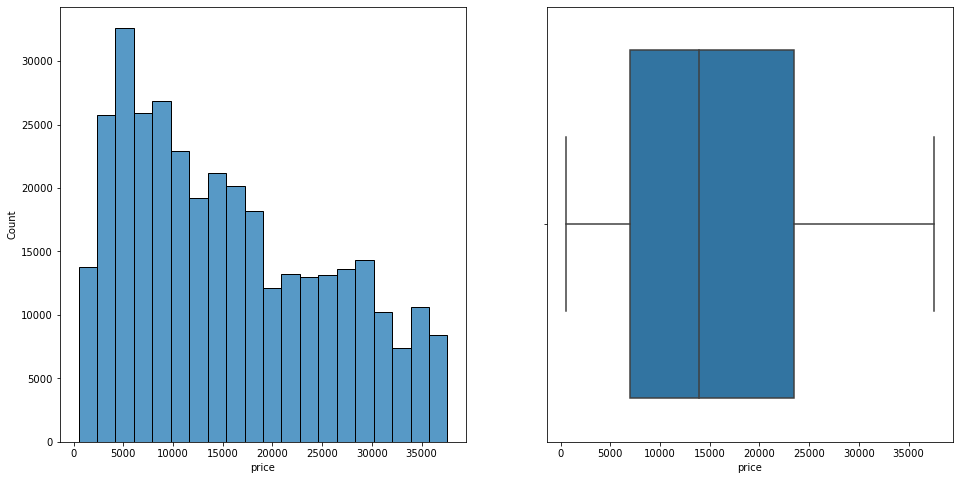

In [207]:
#plotting prices again
plt.figure(figsize=(16,8))
plt.subplot(121)
sns.histplot(data=cars,x='price',bins=20)
plt.subplot(122)
sns.boxplot(data=cars,x='price');

### Year



<AxesSubplot:xlabel='year', ylabel='Count'>

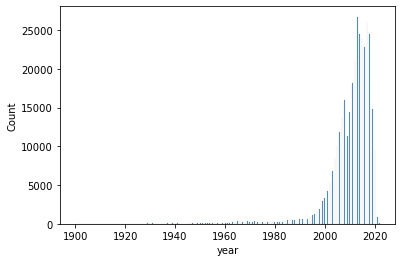

In [208]:
#plotting the histogram of the make of the cars 

sns.histplot(data=cars,x='year')

In [209]:
print(f"Higher year: {cars.year.max()}\nLowest year: {cars.year.min()}")
print("Cars with no manufacturing year value:",cars.year.isnull().sum())

Higher year: 2022.0
Lowest year: 1900.0
Cars with no manufacturing year value: 628


### Age

- Given the manufacturing year of the car and the max year value in the dataset, we can create a new feature called 'age' which gives us a better idea about the car.
- Most of the car have been manufactured in the last 20 years or so. Let's look at the more recent car sales data.

In [210]:
#Dropping the rows with no year value

cars = cars[cars.year.notnull()]

#Calculate the age of the car and store it in a new column 'age'
cars['age'] = cars.year.apply(lambda x: int(2020-x))
print('Row count before:',cars.shape[0])

#Considering more recently manufactured cars(>2000)
cars = cars[cars['age'].between(0,23)]
print('Row count after filtering age:',cars.shape[0])

#dropping the 'year' feature 
print('Feature count',cars.shape[1])
cars.drop('year',axis=1,inplace=True)
print('Feature count after',cars.shape[1])

Row count before: 342004
Row count after filtering age: 324490
Feature count 16
Feature count after 15


/Users/nikhil/Portfolio/used-car-price-prediction/env/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


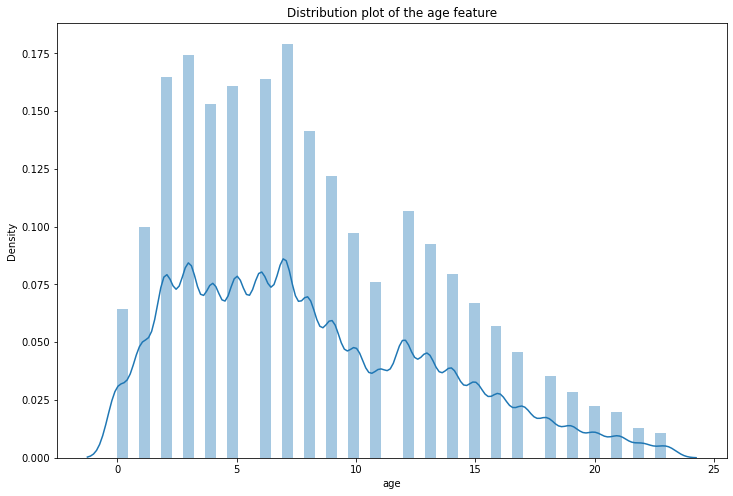

In [211]:
#Plotting the age distribution
plt.figure(figsize=(12,8))
plt.title("Distribution plot of the age feature")
sns.distplot(cars.age);

In [212]:
# plt.figure(figsize=(12,12))
# plt.title("Missing values for each column")
# sns.heatmap(cars.isnull())
# plt.show()

## Condition

<AxesSubplot:xlabel='condition', ylabel='Count'>

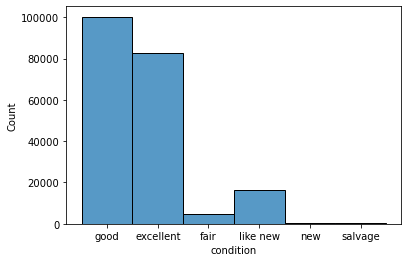

In [213]:
cars.condition.value_counts()
sns.histplot(data=cars,x='condition')

In [214]:
#minimizing the categorical features in condition column

conditions = [
    (cars['condition'].isin(['new','like new'])),
    (cars['condition'].isin(['good','excellent'])),
    (cars['condition'].isin(['fair','salvage']))
    ]

# creating a list of the values we want to assign for each condition
values = [1,2,3]

# create a new column and use np.select to assign values to it using our lists as arguments

#Here I am making an assumption that the car is only sold if it atleast in a 'good' condiiton. This is equivalent 
#to imputing the 'condition' column with its mode. 
cars['new_condition'] = np.select(conditions, values,default=2)
cars.head()

,price,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,age,new_condition
27,33590,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,3GTP1VEC4EG551563,NaN,NaN,pickup,white,6,2
28,22590,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,1GCSCSE06AZ123805,NaN,NaN,pickup,blue,10,2
30,30990,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,5TFRM5F17HX120972,NaN,NaN,pickup,red,3,2
31,15000,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,NaN,rwd,full-size,truck,black,7,2
32,27990,gmc,sierra 2500 hd extended cab,good,8 cylinders,gas,68696.0,clean,other,1GT220CG8CZ231238,4wd,NaN,pickup,black,8,2


In [215]:
#dropping car sales with missing titles and part sales
print('Row count:',cars.shape[1])
cars.drop(cars[cars.title_status.isin(['missing','parts only'])].index,inplace=True)
cars.title_status.value_counts()
print('Row count after',cars.shape[1])

Row count: 16
Row count after 16


In [216]:
#Dropping columns

cars.drop(['model','condition','cylinders','fuel','title_status','transmission','VIN','drive','size'],axis=1,inplace=True)

## NOTE: Will add some of features back for after initial model.

## Test Train Split

In [217]:
#test train split

from sklearn.model_selection import train_test_split

X = cars[['odometer','age','new_condition','manufacturer','type','paint_color']]
y = cars.price

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Preprocessing Pipeline

In [218]:
#Preprocessing Pipeline

from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#Seperating Categorical columns
cat_cols = ['new_condition','manufacturer']

#Seperating Numerical columns
num_cols = ['odometer','age']

#Pipeline for Categorical features
cat_pipe = Pipeline([
    ('imp',SimpleImputer(strategy="most_frequent")),
    ('ohe',OneHotEncoder())
])

#Pipeline for Numerical features
num_pipe = Pipeline([
    ('simp',SimpleImputer(strategy="median")),
    ('ss',StandardScaler())
])

#Column transformer which combines our individual pipelines
preprocessor = ColumnTransformer([
    ('cat_col',cat_pipe,cat_cols),
    ('num_col',num_pipe,num_cols)
],remainder = 'passthrough')

## Model Pipeline

In [219]:
#Model building Pipeline 

from sklearn.linear_model import Ridge,LinearRegression

model = Pipeline([
    ('preprocessor',preprocessor),
    ('model',LinearRegression())
])
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_col',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder())]),
                                                  ['new_condition',
                                                   'manufacturer']),
                                                 ('num_col',
                                                  Pipeline(steps=[('simp',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['odometer', 'age'])])),
                ('model', LinearRegression())])

## Model Evaluation

In [220]:
#Using R-Squared function to score our model

#from sklearn.metrics import r2_squared

model.fit(X_train,y_train)
model.score(X_test,y_test)

ValueError: For a sparse output, all columns should be a numeric or convertible to a numeric.